In [1]:
from pathlib import Path
import yaml
import os
import numpy as np
import cv2

In [2]:
output_path = Path("/media/Data/Data/DavidDylan/tube_output2/train")
scene_id = 5
object_id = 11
scene_folder_name = f"{scene_id:06d}"


scene_path = output_path / scene_folder_name


In [3]:
def get_indexes_with_obj_id(scene_gt, obj_id):
    indexes_by_image = {}

    for image_id, annotations in scene_gt.items():
        indexes_for_image = []
        for i, annotation in enumerate(annotations):
            if annotation['obj_id'] == str(obj_id):
                indexes_for_image.append(i)
        indexes_by_image[image_id] = indexes_for_image

    return indexes_by_image

scene_gt_path = scene_path / "scene_gt.json"
with open(scene_gt_path, "r") as f:
  scene_gt_json = yaml.load(f, Loader=yaml.FullLoader)

indexes = get_indexes_with_obj_id(scene_gt_json, object_id)


In [4]:
metrics_per_experiment = {} 

import matplotlib.pyplot as plt
import math

experiment_folders = sorted([folder for folder in output_path.iterdir() if "_" in folder.name and scene_folder_name in folder.name])
# print(experiment_folders)
for image_id, indexes_for_image in indexes.items():
    for index in indexes_for_image:
        mask_name = f"{int(image_id):06d}_{index:06d}.png"
        gt_mask_path = scene_path / "mask_visib" / mask_name

        # Load gt_mask 
        gt_mask = cv2.imread(str(gt_mask_path), cv2.IMREAD_GRAYSCALE)

        # Calculate the number of rows and columns for the subplot grid
        num_experiments = len(experiment_folders)
        # num_cols = math.ceil((num_experiments + 1) / 3)  # +1 for the ground truth mask
        # num_rows = 3

        # # Create a figure with subplots
        # fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))  # Adjust figsize as needed

        # # Display the ground truth mask in the first subplot
        # axes[0, 0].imshow(gt_mask, cmap='gray')
        # axes[0, 0].set_title('Ground Truth')
        # axes[0, 0].axis('off')

        # Display experiment masks in the remaining subplots
        for i, folder in enumerate(experiment_folders):
            experiment = folder.name.split("_")[1]
            experiment_mask_path = folder / "mask_visib" / mask_name
            # Load experiment_mask
            experiment_mask = cv2.imread(str(experiment_mask_path), cv2.IMREAD_GRAYSCALE)

            # row = (i + 1) // num_cols  # Calculate row index
            # col = (i + 1) % num_cols  # Calculate column index

            # axes[row, col].imshow(experiment_mask, cmap='gray')
            # axes[row, col].set_title(f'Experiment {experiment}')
            # axes[row, col].axis('off')

            # Calculate metrics 
            intersection = np.logical_and(gt_mask, experiment_mask)
            union = np.logical_or(gt_mask, experiment_mask)
            true_positives = np.count_nonzero(intersection)
            false_positives = np.count_nonzero(experiment_mask) - true_positives
            false_negatives = np.count_nonzero(gt_mask) - true_positives

            precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
            recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0  

            iou = true_positives / np.count_nonzero(union) if np.count_nonzero(union) != 0 else 0

            if experiment not in metrics_per_experiment:
                metrics_per_experiment[experiment] = {'precision': [], 'recall': [], 'iou': []}
            metrics_per_experiment[experiment]['precision'].append(precision)
            metrics_per_experiment[experiment]['recall'].append(recall)
            metrics_per_experiment[experiment]['iou'].append(iou)

        # plt.tight_layout()
        # plt.show()

# Extract numeric part from keys, convert to integers, and sort
experiment_metrics = sorted([(int(exp.lstrip('0')), metrics) for exp, metrics in metrics_per_experiment.items()])

# Print metrics in sorted order
for exp_num, metrics in experiment_metrics:
    exp_str = f"{exp_num:03d}" 
    avg_precision = sum(metrics['precision']) / len(metrics['precision'])
    avg_recall = sum(metrics['recall']) / len(metrics['recall'])
    avg_iou = sum(metrics['iou']) / len(metrics['iou'])
    print(f"Experiment: {exp_str}")
    print(f"  Average Precision: {avg_precision}")
    print(f"  Average Recall: {avg_recall}")
    print(f"  Average IoU: {avg_iou}")

Experiment: 003
  Average Precision: 0.18985133228051462
  Average Recall: 0.8862094428138694
  Average IoU: 0.1878649717135149
Experiment: 004
  Average Precision: 0.22279109084330947
  Average Recall: 0.8948358868456618
  Average IoU: 0.2209161421765669
Experiment: 005
  Average Precision: 0.3141087186243024
  Average Recall: 0.8766105877622519
  Average IoU: 0.3099843942952483
Experiment: 006
  Average Precision: 0.46526877902579833
  Average Recall: 0.9549407998549669
  Average IoU: 0.45348356922353966
Experiment: 007
  Average Precision: 0.6749198613265742
  Average Recall: 0.9397494011593547
  Average IoU: 0.6543595329523201
Experiment: 008
  Average Precision: 0.721531621581186
  Average Recall: 0.9579672093900136
  Average IoU: 0.7025977478936449
Experiment: 009
  Average Precision: 0.8999718098185875
  Average Recall: 0.9642114116596137
  Average IoU: 0.8723870078094842
Experiment: 010
  Average Precision: 0.9275108734565062
  Average Recall: 0.9638873414755219
  Average IoU: 

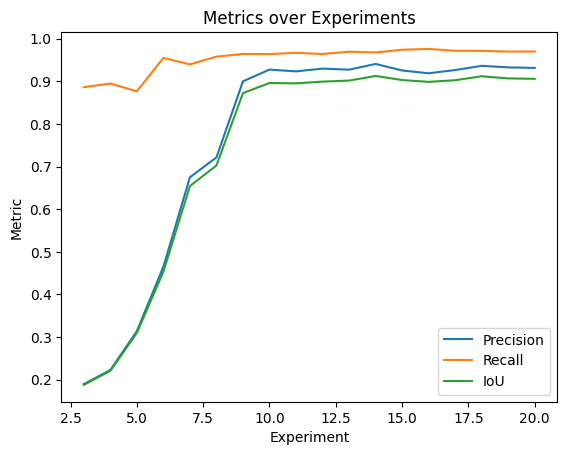

In [6]:

# plot experiment metrics recall precision and IoU over the experiments
experiments = [exp_num for exp_num, _ in experiment_metrics[:-1]]
precisions = [sum(metrics['precision']) / len(metrics['precision']) for _, metrics in experiment_metrics[:-1]]
recalls = [sum(metrics['recall']) / len(metrics['recall']) for _, metrics in experiment_metrics[:-1]]
ious = [sum(metrics['iou']) / len(metrics['iou']) for _, metrics in experiment_metrics[:-1]]

plt.plot(experiments, precisions, label='Precision')
plt.plot(experiments, recalls, label='Recall')
plt.plot(experiments, ious, label='IoU')
plt.xlabel('Experiment')
plt.ylabel('Metric')
plt.title('Metrics over Experiments')
plt.legend()
plt.show()

